<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Тестовое-задание" data-toc-modified-id="Тестовое-задание-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Тестовое задание</a></span><ul class="toc-item"><li><span><a href="#2.-Кластеризация" data-toc-modified-id="2.-Кластеризация-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>2. Кластеризация</a></span></li></ul></li></ul></div>

# Тестовое задание

**Общие требования:**
1. приложить файл requirements.txt с пакетами, которые необходимо установить для воспроизведения результата.
1. комментировать ход решения.
1. **дополнительное задание на подумать:** есть ли метрики, которые лучше подходят для задачи?
1. **дополнительное задание на подумать:** как изменилось бы решение, если бы модель необходимо было встроить в другую систему, используя Java?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hierarchy

from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, classification_report, roc_curve,roc_auc_score,silhouette_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
%matplotlib inline

In [2]:
## 1. Классификация
task1data = pd.read_csv('./task1_train_v3.csv', sep=';',header=0,index_col=False)
task1data.head()

,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,y
0,33.237371,3.0,-0.186197,0.345662,0.156862,2.422278,2.091643,2.091643,0
1,31.442961,4.0,1.190667,-1.787377,2.315938,-0.169454,3.433385,3.433385,0
2,33.820143,2.0,0.706350,1.437075,0.328561,1.883888,0.880765,0.880765,1
3,32.100224,NaN,1.724461,-0.266465,52.409804,-0.320023,1.876500,1.876500,0
4,33.219532,NaN,2.260290,1.136786,1.750040,-0.115895,0.602036,0.602036,0


**Задача:** для заданного набора данных (task1_train.csv) построить классификатор. Метрика: AUC ROC

In [3]:
task1data.shape

(5000, 9)

В характеристике stat_2 есть пробелы (nan), лучше посмотреть как обстоят дела со всеми характеристиками

In [4]:
task1data.isna().sum()


stat_1    167
stat_2    163
stat_3    153
stat_4    151
stat_5    150
stat_6    142
stat_7    147
stat_8    171
y           0
dtype: int64

В среднем, у всех статистик есть такие пробелы, они небольшие и какая-то отдельная характеристика не выделяется, а значит, мы просто отфильтруем эти "плохие" наблюдения.

In [5]:
task1data.groupby(['y']).size()

y
0    2488
1    2512
dtype: int64

Отклик **y** распределён неплохо, ни один из 2х классов не доминирует. 

Поскольку характеристик всего 8, можно спокойно посмотреть на их гистограммы.

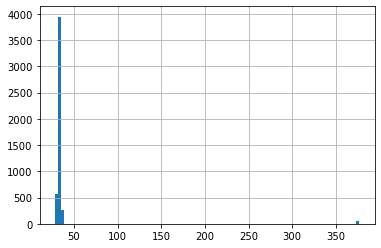

In [6]:
task1data['stat_1'].hist(bins=100);

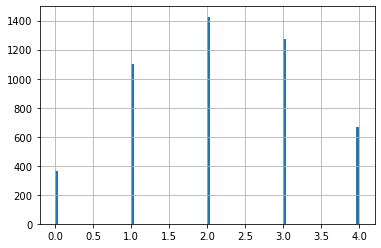

In [7]:
task1data['stat_2'].hist(bins=100);

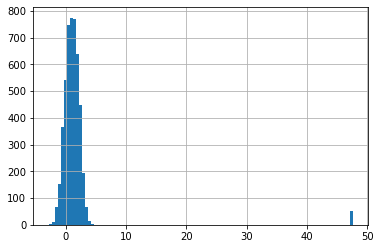

In [8]:
task1data['stat_3'].hist(bins=100);

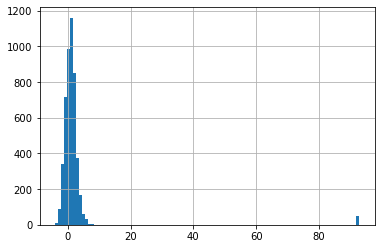

In [9]:
task1data['stat_4'].hist(bins=100);

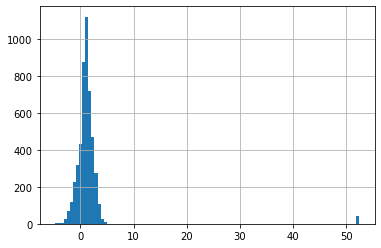

In [10]:
task1data['stat_5'].hist(bins=100);

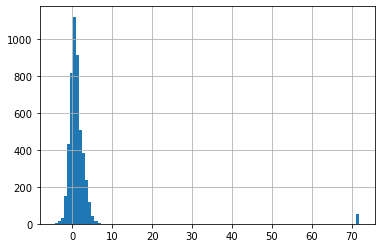

In [11]:
task1data['stat_6'].hist(bins=100);

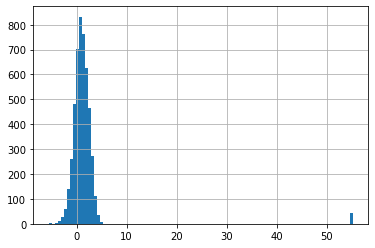

In [12]:
task1data['stat_7'].hist(bins=100);

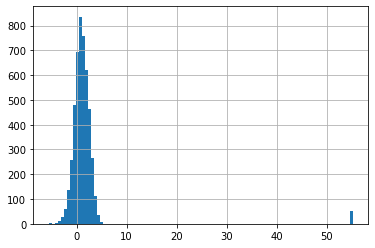

In [13]:
task1data['stat_8'].hist(bins=100);

Судя по гистограммам, есть явные выбросы, которые стоит убрать.

In [14]:
valid_task1data = task1data.drop(task1data[(task1data['stat_1']) > 350].index)
valid_task1data = valid_task1data.drop(valid_task1data[(valid_task1data['stat_3']  > 40)].index)
valid_task1data = valid_task1data.drop(valid_task1data[(valid_task1data['stat_4']  > 80)].index)
valid_task1data = valid_task1data.drop(valid_task1data[(valid_task1data['stat_5']  > 50)].index)
valid_task1data = valid_task1data.drop(valid_task1data[(valid_task1data['stat_6']  > 70)].index)
valid_task1data = valid_task1data.drop(valid_task1data[(valid_task1data['stat_7']  > 50)].index)
valid_task1data = valid_task1data.drop(valid_task1data[(valid_task1data['stat_8']  > 50)].index)
valid_task1data = valid_task1data.dropna()
valid_task1data.shape


(3604, 9)

In [15]:
valid_task1data.describe()

,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,y
count,3604.000000,3604.000000,3604.000000,3604.000000,3604.000000,3604.000000,3604.000000,3604.000000,3604.000000
mean,33.002722,2.163152,1.011586,1.010319,1.005178,0.989631,0.986800,0.986800,0.512209
std,1.295685,1.152543,1.095594,1.642485,1.236824,1.489988,1.407795,1.407795,0.499920
min,28.115517,0.000000,-2.475602,-4.052885,-4.409971,-4.330098,-5.177570,-5.177570,0.000000
25%,32.130363,1.000000,0.243871,-0.111420,0.383056,0.012306,0.050152,0.050152,0.000000
50%,32.922419,2.000000,1.018690,1.010693,1.093619,0.837259,0.983449,0.983449,1.000000
75%,33.873791,3.000000,1.797441,2.037901,1.764897,1.834479,1.976723,1.976723,1.000000
max,37.693455,4.000000,4.354973,8.753420,5.048357,6.779979,5.224599,5.224599,1.000000


array([[<AxesSubplot:xlabel='stat_1', ylabel='stat_1'>,
        <AxesSubplot:xlabel='stat_2', ylabel='stat_1'>,
        <AxesSubplot:xlabel='stat_3', ylabel='stat_1'>,
        <AxesSubplot:xlabel='stat_4', ylabel='stat_1'>,
        <AxesSubplot:xlabel='stat_5', ylabel='stat_1'>,
        <AxesSubplot:xlabel='stat_6', ylabel='stat_1'>,
        <AxesSubplot:xlabel='stat_7', ylabel='stat_1'>,
        <AxesSubplot:xlabel='stat_8', ylabel='stat_1'>],
       [<AxesSubplot:xlabel='stat_1', ylabel='stat_2'>,
        <AxesSubplot:xlabel='stat_2', ylabel='stat_2'>,
        <AxesSubplot:xlabel='stat_3', ylabel='stat_2'>,
        <AxesSubplot:xlabel='stat_4', ylabel='stat_2'>,
        <AxesSubplot:xlabel='stat_5', ylabel='stat_2'>,
        <AxesSubplot:xlabel='stat_6', ylabel='stat_2'>,
        <AxesSubplot:xlabel='stat_7', ylabel='stat_2'>,
        <AxesSubplot:xlabel='stat_8', ylabel='stat_2'>],
       [<AxesSubplot:xlabel='stat_1', ylabel='stat_3'>,
        <AxesSubplot:xlabel='stat_2', ylabel='

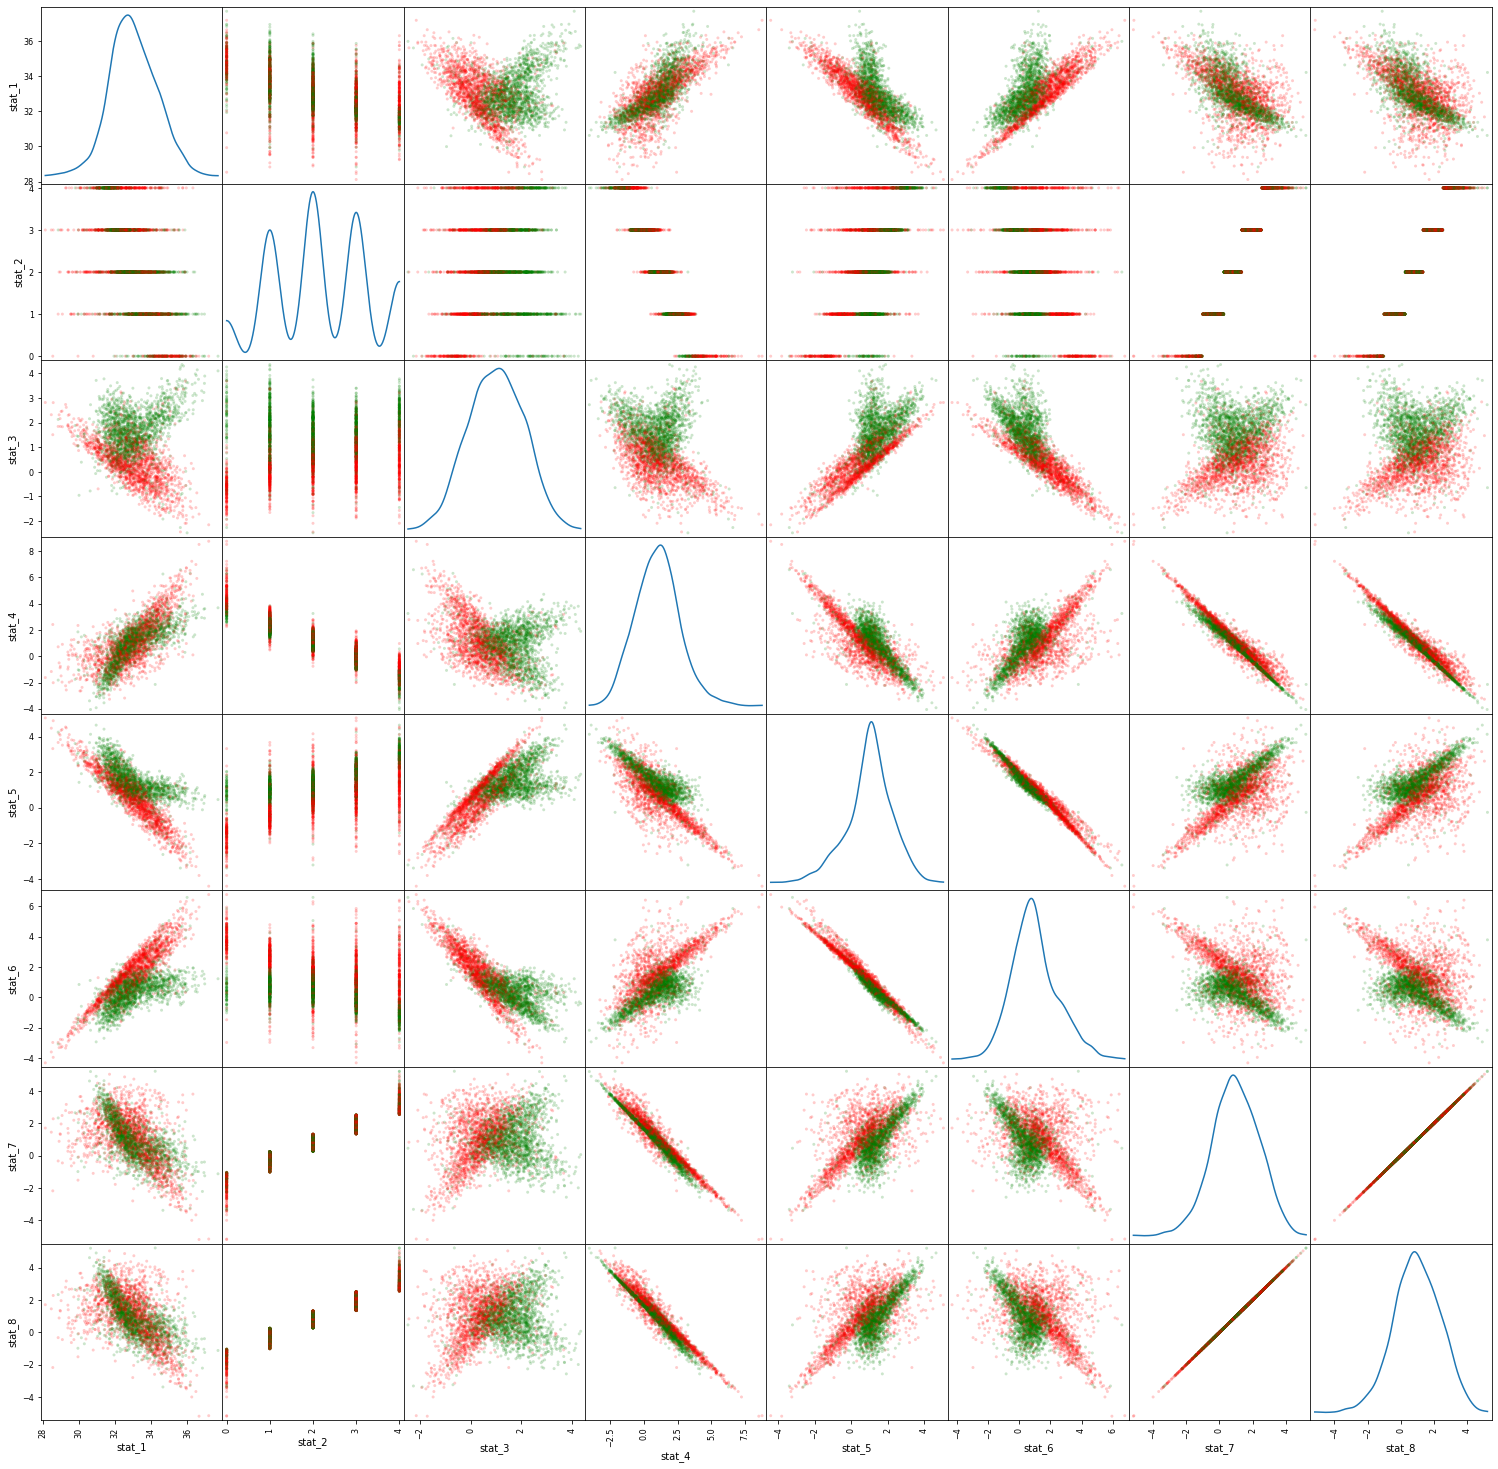

In [16]:

colors={'1':'green', '0':'red'}
valid_task1data['y'] = valid_task1data['y'].astype(str)
scatter_matrix(valid_task1data,figsize=(26,26), diagonal='kde',alpha=0.2, c=valid_task1data['y'].replace(colors))

Диаграммы рассеивания могли нам указать на явно значимиые характеристики, но не в этом случае. После того, как убрали выбросы ещё раз взглянем на гистограмму, к примеру, первой характеристики.

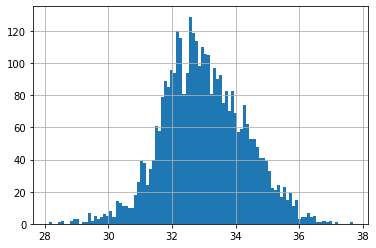

In [17]:
valid_task1data['stat_1'].hist(bins=100);

Если внимательно взглянуть на диаграммы рассеивания, то можно заметить что stat_5 и stat_6 практически линейно друг от друга зависят, проверить это можем с помощью корреляции Пирсона.

In [18]:
valid_task1data['stat_5'].corr(valid_task1data['stat_6']),valid_task1data['stat_6'].corr(valid_task1data['stat_5'])


(-0.9815301021211328, -0.9815301021211328)

Что и требовалось доказать. Уберём, допустим, 5ю характеристику, она избыточна.


7 и 8 характеристики тоже смущают.


In [19]:
valid_task1data['stat_7'].corr(valid_task1data['stat_8']),valid_task1data['stat_8'].corr(valid_task1data['stat_7'])


(1.0, 1.0)

7ю характеристику в сад, но смущают 8я и 4я....

In [20]:
valid_task1data['stat_8'].corr(valid_task1data['stat_4']),valid_task1data['stat_4'].corr(valid_task1data['stat_8'])


(-0.9659334604990996, -0.9659334604990994)

4ю тоже в сад.

array([[<AxesSubplot:xlabel='stat_1', ylabel='stat_1'>,
        <AxesSubplot:xlabel='stat_2', ylabel='stat_1'>,
        <AxesSubplot:xlabel='stat_3', ylabel='stat_1'>,
        <AxesSubplot:xlabel='stat_6', ylabel='stat_1'>,
        <AxesSubplot:xlabel='stat_8', ylabel='stat_1'>],
       [<AxesSubplot:xlabel='stat_1', ylabel='stat_2'>,
        <AxesSubplot:xlabel='stat_2', ylabel='stat_2'>,
        <AxesSubplot:xlabel='stat_3', ylabel='stat_2'>,
        <AxesSubplot:xlabel='stat_6', ylabel='stat_2'>,
        <AxesSubplot:xlabel='stat_8', ylabel='stat_2'>],
       [<AxesSubplot:xlabel='stat_1', ylabel='stat_3'>,
        <AxesSubplot:xlabel='stat_2', ylabel='stat_3'>,
        <AxesSubplot:xlabel='stat_3', ylabel='stat_3'>,
        <AxesSubplot:xlabel='stat_6', ylabel='stat_3'>,
        <AxesSubplot:xlabel='stat_8', ylabel='stat_3'>],
       [<AxesSubplot:xlabel='stat_1', ylabel='stat_6'>,
        <AxesSubplot:xlabel='stat_2', ylabel='stat_6'>,
        <AxesSubplot:xlabel='stat_3', ylabel=

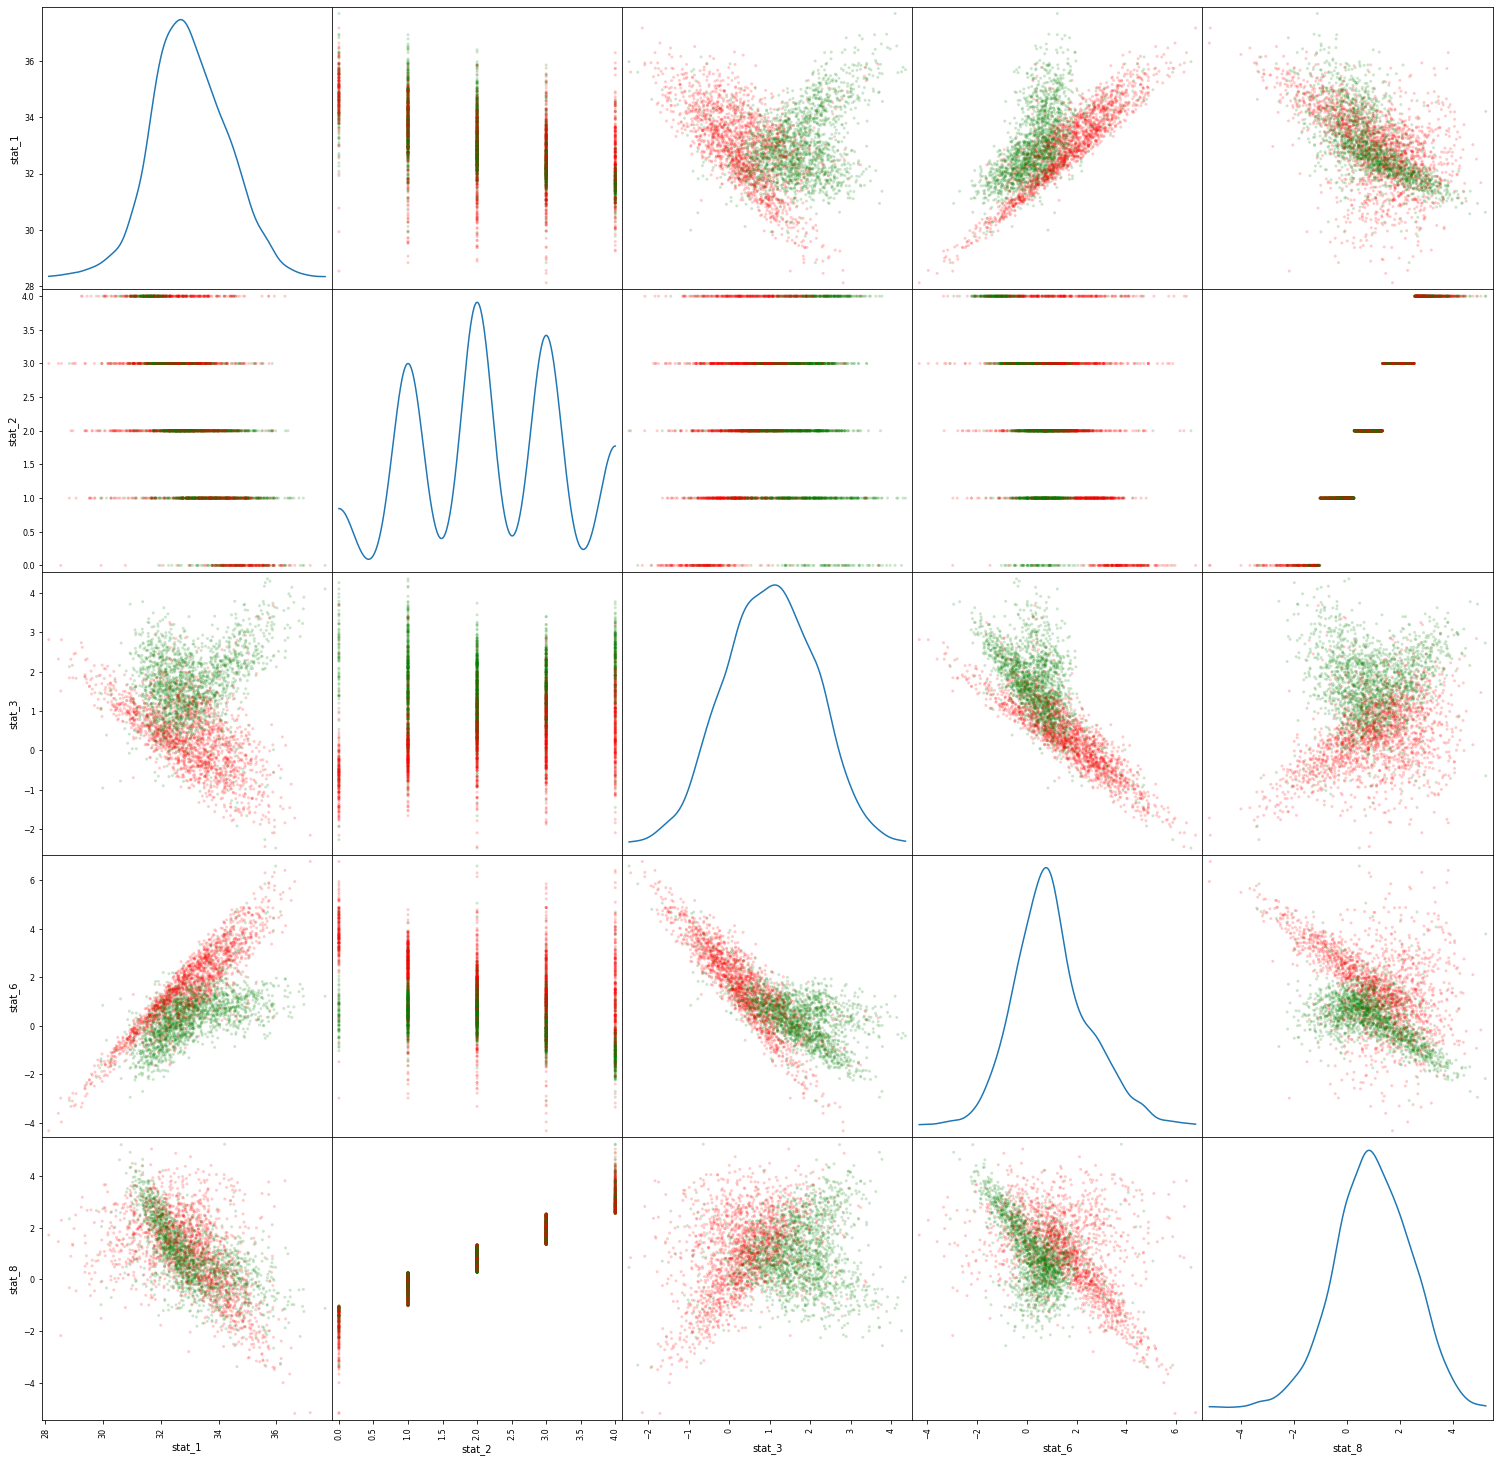

In [21]:
filtered_valid_task1data=valid_task1data.drop('stat_5',axis=1)
filtered_valid_task1data=filtered_valid_task1data.drop('stat_4',axis=1)
filtered_valid_task1data=filtered_valid_task1data.drop('stat_7',axis=1)
x = filtered_valid_task1data.drop('y',axis=1)
y = filtered_valid_task1data['y']
colors={'1':'green', '0':'red'}
filtered_valid_task1data['y'] = filtered_valid_task1data['y'].astype(str)
scatter_matrix(filtered_valid_task1data,figsize=(26,26), diagonal='kde',alpha=0.2, c=filtered_valid_task1data['y'].replace(colors))



In [22]:
train_x,test_and_validate_x,train_y,test_and_validate_y= train_test_split(x, y, stratify=y,  test_size=0.4, random_state=42)
{'train': train_y, 'test_and_ validate': test_and_validate_y}
train_y.groupby(train_y).count()

y
0    1055
1    1107
Name: y, dtype: int64

Распилить по индексу 3000 оказалось вполне пригодным решением, **y** сохранил репрезентативность и в подвыборках.
Но мы воспользуемся **train_test_split**. Судя по тому,что значения отклик **y** принимает только 0 и 1, мы можем рассматривать эту шкалу как номинативную (бинарный индикатор), а значит можно попробовать использовать регрессию или случайный лес, а лучше GBM.

In [23]:
validate_x,test_x,validate_y,test_y= train_test_split(test_and_validate_x, test_and_validate_y, stratify=test_and_validate_y,  test_size=0.5, random_state=42)
{'train': train_y, 'test': test_y}
validate_y.groupby(validate_y).count(),test_y.groupby(test_y).count()


(y
 0    351
 1    370
 Name: y, dtype: int64,
 y
 0    352
 1    369
 Name: y, dtype: int64)

Выборка валидации использована для подгонки стандартных внешних параметров модели. Сделаем что-то наподобии gridsearch только своими руками через циклы! В качестве промежуточной оценки для валидации возьму **accuracy**

In [24]:
max_score = -100000
for criterion in ('friedman_mse','mae','mse'):
    for n_estimators in (100,110,120,130):
        for max_depth in range(1,5):
            model = GradientBoostingClassifier(random_state=52,
                                               max_depth=max_depth, # глубина каждого дерева (значение по умолчанию)
                                               n_estimators=n_estimators, # количество деревьев (значение по умолчанию)
                                               criterion=criterion # функция измерения качества разбиения
                                              )
            model.fit(train_x, train_y)
            pred_validate_y = model.predict(validate_x)
            score = accuracy_score(pred_validate_y , validate_y)            
            max_score = max(score, max_score)
            print('criterion - ' + criterion + ' n_estimators - '+ str(n_estimators)+' maxdepth - '+str(max_depth)+' : '+ str(score))
max_score

criterion - friedman_mse n_estimators - 100 maxdepth - 1 : 0.8543689320388349
criterion - friedman_mse n_estimators - 100 maxdepth - 2 : 0.8543689320388349
criterion - friedman_mse n_estimators - 100 maxdepth - 3 : 0.8668515950069348
criterion - friedman_mse n_estimators - 100 maxdepth - 4 : 0.8668515950069348
criterion - friedman_mse n_estimators - 110 maxdepth - 1 : 0.8543689320388349
criterion - friedman_mse n_estimators - 110 maxdepth - 2 : 0.8599167822468793
criterion - friedman_mse n_estimators - 110 maxdepth - 3 : 0.8654646324549237
criterion - friedman_mse n_estimators - 110 maxdepth - 4 : 0.8654646324549237
criterion - friedman_mse n_estimators - 120 maxdepth - 1 : 0.8529819694868238
criterion - friedman_mse n_estimators - 120 maxdepth - 2 : 0.8571428571428571
criterion - friedman_mse n_estimators - 120 maxdepth - 3 : 0.8654646324549237
criterion - friedman_mse n_estimators - 120 maxdepth - 4 : 0.869625520110957
criterion - friedman_mse n_estimators - 130 maxdepth - 1 : 0.8529

D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 100 maxdepth - 1 : 0.7794729542302358


D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 100 maxdepth - 2 : 0.8016643550624133


D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 100 maxdepth - 3 : 0.8030513176144244


D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 100 maxdepth - 4 : 0.8072122052704577


D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 110 maxdepth - 1 : 0.7794729542302358


D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 110 maxdepth - 2 : 0.8016643550624133


D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 110 maxdepth - 3 : 0.8030513176144244


D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 110 maxdepth - 4 : 0.8072122052704577


D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 120 maxdepth - 1 : 0.7794729542302358


D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 120 maxdepth - 2 : 0.8016643550624133


D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 120 maxdepth - 3 : 0.8030513176144244


D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 120 maxdepth - 4 : 0.8072122052704577


D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 130 maxdepth - 1 : 0.7794729542302358


D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 130 maxdepth - 2 : 0.8016643550624133


D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 130 maxdepth - 3 : 0.8030513176144244


D:\Users\Eskander\Anaconda3\envs\postflop-income\lib\site-packages\sklearn\ensemble\_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


criterion - mae n_estimators - 130 maxdepth - 4 : 0.8072122052704577
criterion - mse n_estimators - 100 maxdepth - 1 : 0.8543689320388349
criterion - mse n_estimators - 100 maxdepth - 2 : 0.8543689320388349
criterion - mse n_estimators - 100 maxdepth - 3 : 0.8668515950069348
criterion - mse n_estimators - 100 maxdepth - 4 : 0.8668515950069348
criterion - mse n_estimators - 110 maxdepth - 1 : 0.8543689320388349
criterion - mse n_estimators - 110 maxdepth - 2 : 0.8599167822468793
criterion - mse n_estimators - 110 maxdepth - 3 : 0.8654646324549237
criterion - mse n_estimators - 110 maxdepth - 4 : 0.8654646324549237
criterion - mse n_estimators - 120 maxdepth - 1 : 0.8529819694868238
criterion - mse n_estimators - 120 maxdepth - 2 : 0.8571428571428571
criterion - mse n_estimators - 120 maxdepth - 3 : 0.8654646324549237
criterion - mse n_estimators - 120 maxdepth - 4 : 0.869625520110957
criterion - mse n_estimators - 130 maxdepth - 1 : 0.8529819694868238
criterion - mse n_estimators - 130 

0.869625520110957

Видим, что максимальная точность достигается при параметрах 120, 4, friedman_mse. Глубину больше 4х не будем рассматривать, так как есть эвристики, что слишком глубокие деревья любят переобучаться.

In [25]:
model = GradientBoostingClassifier(random_state=52,
                                               max_depth=4, # глубина каждого дерева (значение по умолчанию)
                                               n_estimators=120, # количество деревьев (значение по умолчанию)
                                               criterion='friedman_mse' # функция измерения качества разбиения
                                              )
model.fit(train_x, train_y)

GradientBoostingClassifier(max_depth=4, n_estimators=120, random_state=52)

In [26]:
pred_test_y = model.predict_proba(test_x)
print(pred_test_y)

[[0.94545052 0.05454948]
 [0.94801004 0.05198996]
 [0.05654832 0.94345168]
 ...
 [0.04617624 0.95382376]
 [0.96227236 0.03772764]
 [0.06804888 0.93195112]]


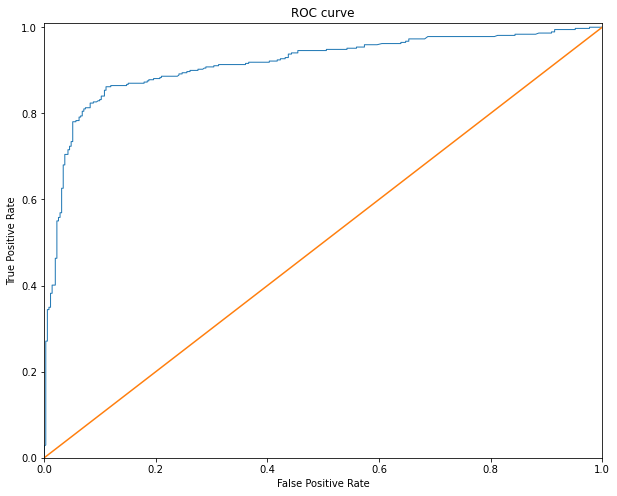

array([1.9901917 , 0.9901917 , 0.97876105, 0.97201825, 0.97132625,
       0.95130738, 0.95122493, 0.95009935, 0.94974123, 0.94530223,
       0.94506965, 0.94193279, 0.94128572, 0.93880337, 0.93880002,
       0.93082626, 0.93081162, 0.9296681 , 0.92964133, 0.92817016,
       0.92754991, 0.92586276, 0.92562732, 0.92077757, 0.91964603,
       0.91179127, 0.91164466, 0.91053488, 0.91043329, 0.91029735,
       0.90989536, 0.90285303, 0.9020681 , 0.89799678, 0.89742198,
       0.89232307, 0.8915561 , 0.89046158, 0.88797553, 0.88635563,
       0.88558119, 0.86221129, 0.86030749, 0.82235937, 0.82187539,
       0.80347674, 0.80303899, 0.79880067, 0.79878113, 0.79285053,
       0.78945083, 0.78161529, 0.78156851, 0.73367461, 0.72141062,
       0.72119261, 0.71142116, 0.69680696, 0.69404462, 0.69047632,
       0.68864503, 0.67264632, 0.66994979, 0.65031721, 0.65024469,
       0.65011357, 0.64670253, 0.63531348, 0.62326432, 0.62308164,
       0.61192289, 0.60980916, 0.60723406, 0.60573486, 0.60229

In [27]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(test_y.astype('int'), pred_test_y[:,1], pos_label=1)
lw = 1
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1],[0, 1])
plt.xlim([0.0, 1.])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()
thresholds

Порог стоит выбрать таким, чтобы tpr - fpr был максимальным.

In [28]:
max_index = np.argmax(tpr-fpr)
roc_score = roc_auc_score(test_y.astype('int'), pred_test_y[:,1])
print('порог - '+ str(thresholds[max_index])) 
print('true positive rate(recall) - '+ str(tpr[max_index]))# 
print('false positive rate - '+ str(fpr[max_index]))
print('roc score - ' +str(roc_score))

порог - 0.5450351169106747
true positive rate(recall) - 0.8617886178861789
false positive rate - 0.11079545454545454
roc score - 0.9144917159398867


> как изменилось бы решение, если бы модель необходимо было встроить в другую систему, используя Java?

Первое, что приходит на ум, это организовать отдельный сервис **А** с уже предобученной моделью и производящей результат предсказания.
1. Flask в качестве библиотеки http для оргазинации сервера и любая, к примеру httpclientlite, библиотека на стороне Java для организации клиента. (если нужен real-time)
2. Организовать 2 очереди с помощью любого подходящего хранилища (mysql или тот же zookeeper), в первой будут запросы на предсказание, во второй результаты.
3. Возможно, стоит подумать об отказе от Python в пользу Hadoop кластера и SparkML на его основе (кстати опыт в этих вещах у меня есть :-) ).

В любом случае, дообучение и обновление можно организовать в виде jenkins/teamcity или другого варианта cron-таски, а саму модель хранить в виде ресурса, к примеру sklearn.externals.joblib дампа, который будет читаться сервисом **А** на старте.

> есть ли метрики, которые лучше подходят для задачи?

Основным критерием отказа от **accuracy** обычно считается несбалансированность в классах, 
у нас же объектов одного и другого типа примерно одинаковое количество, 
поэтому отказываться от accuracy не имеет смысла.

Точно так же и precision/recall/f-score не стоит списывать со счетов.

In [29]:
def compare_to_threshold(x):
    return x > thresholds[max_index]
y_pred_test_no_prob = compare_to_threshold(pred_test_y[:,1])
y_pred_test_no_prob = y_pred_test_no_prob.astype(int)
y_pred_test_no_prob = y_pred_test_no_prob.astype(str).astype(object)

In [30]:
accuracy_score(test_y, y_pred_test_no_prob)

0.8737864077669902

In [31]:

print(classification_report(test_y, y_pred_test_no_prob))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       352
           1       0.89      0.86      0.87       369

    accuracy                           0.87       721
   macro avg       0.87      0.87      0.87       721
weighted avg       0.87      0.87      0.87       721



Задача выглядит так, что её можно проверить с помощью логистической регрессии.

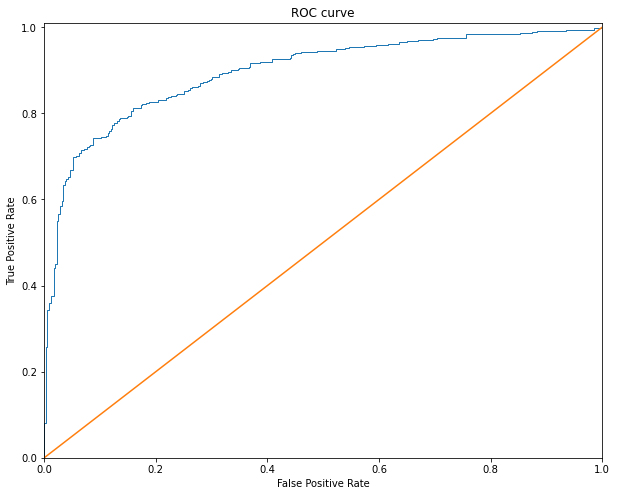

array([1.99728939, 0.99728939, 0.97234156, 0.97144033, 0.90122728,
       0.90113018, 0.86566825, 0.86501165, 0.85873775, 0.85805737,
       0.85366699, 0.85150206, 0.81821502, 0.81742414, 0.81367397,
       0.81234176, 0.75589864, 0.75401963, 0.74467495, 0.74339482,
       0.72647275, 0.72641246, 0.72429136, 0.72227214, 0.69772187,
       0.69720363, 0.68974609, 0.6892693 , 0.68187436, 0.68172807,
       0.68148605, 0.6790308 , 0.66755505, 0.66537148, 0.64450617,
       0.63669197, 0.63652096, 0.63079573, 0.62800692, 0.627545  ,
       0.62059673, 0.61343196, 0.61095815, 0.60740698, 0.60674553,
       0.6044438 , 0.60135472, 0.59449732, 0.59365062, 0.59015517,
       0.58210353, 0.57368673, 0.57140656, 0.56300246, 0.56125476,
       0.55576154, 0.54651407, 0.54218148, 0.53932626, 0.53901428,
       0.53445097, 0.53332556, 0.51987958, 0.51937465, 0.51845618,
       0.51392784, 0.51186533, 0.51067377, 0.50971431, 0.50833938,
       0.50827636, 0.49685234, 0.49529677, 0.4893605 , 0.48373

In [32]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42,solver='liblinear', multi_class='ovr', penalty='l2')
# help(LogisticRegression)
model.fit(train_x, train_y)
linear_pred_test_y=model.predict_proba(test_x)
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(test_y.astype('int'), linear_pred_test_y[:,1], pos_label=1)
lw = 1
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1],[0, 1])
plt.xlim([0.0, 1.])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()
thresholds

In [33]:
max_index = np.argmax(tpr-fpr)
roc_score = roc_auc_score(test_y.astype('int'), linear_pred_test_y[:,1])
print('порог - '+ str(thresholds[max_index])) 
print('true positive rate(recall) - '+ str(tpr[max_index]))# 
print('false positive rate - '+ str(fpr[max_index]))
print('roc score - ' +str(roc_score))

порог - 0.5821035281741218
true positive rate(recall) - 0.7425474254742548
false positive rate - 0.08806818181818182
roc score - 0.8963337644740084


**TPR** тут конечно меньше, но и **FPR** меньше, так что тут нужно больше данных от заказчика о, том что хочется увидеть в итоге. Можно сказать, что логрегрессия относит к классу 1 большее число объектов чем GBM. В тоже время, площадь под кривой у GBM явно больше, поэтому он предпочтительнее.

## 2. Кластеризация

**Задача:**
кластеризовать заданный набор данных (task2.csv). Предложить метрику и проверить качество.

In [34]:
task2data = pd.read_csv('./task2_v3.csv', sep=';',header=0,index_col=False)
task2data.head()

,stat_1,stat_2,stat_3,stat_4
0,-1.968067,-22.370058,-11.385996,-19.388304
1,7.796681,-9.686054,-7.386393,11.636603
2,11.232707,-11.616259,-13.963754,11.035038
3,-7.431386,-2.881275,-16.752395,-20.350752
4,9.229358,-5.420281,-11.678623,13.369752


In [35]:
task2data.describe()

,stat_1,stat_2,stat_3,stat_4
count,870.000000,870.000000,870.000000,870.000000
mean,4.384614,-1.617318,-6.654072,2.217223
std,9.959393,8.916936,10.150783,13.602365
min,-24.165148,-22.370058,-23.736146,-29.212177
25%,-4.869408,-9.191140,-14.590652,-11.301833
50%,8.618721,-0.432860,-10.882193,5.024653
75%,12.198911,5.715954,3.724942,13.610070
max,21.587683,22.509571,23.266483,20.763125


Стандартизировать характеристики не нужно, так как нет какой-то доминирующей среди всех. Поэтому кстати можно спокойно использовать euclidian расстояние.  Можно начать с иерархического кластерного анализа.

Расстояние между кластерами Ward и между объектами euclidean является стандартном де-факто. 

In [36]:
pd.options.display.float_format = '{:,.2f}'.format
linkage = hierarchy.linkage(task2data, 
                            'ward', #расстояние между кластерами
                            'euclidean' #расстояние между единичными объектами
                           )
linkage


array([[3.10000000e+01, 8.02000000e+02, 2.94369524e-01, 2.00000000e+00],
       [3.90000000e+01, 4.86000000e+02, 3.44441206e-01, 2.00000000e+00],
       [7.11000000e+02, 7.39000000e+02, 3.73334902e-01, 2.00000000e+00],
       ...,
       [1.71000000e+03, 1.73100000e+03, 2.66640135e+02, 3.80000000e+02],
       [1.73400000e+03, 1.73600000e+03, 4.31859327e+02, 6.70000000e+02],
       [1.73500000e+03, 1.73700000e+03, 5.85321642e+02, 8.70000000e+02]])

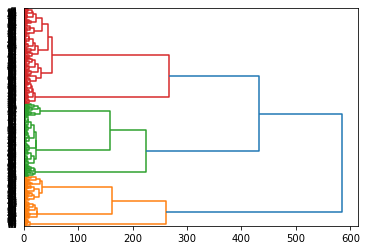

In [37]:
dendrogram = hierarchy.dendrogram(linkage, orientation='right')

In [38]:
for dist in (10,15,30,60,120,190,260,400,500):
    cluster_res = hierarchy.fcluster(linkage,dist, 'distance')
    print('силуэт - ' + str(silhouette_score(task2data, cluster_res)) + ' количество кластеров - ' + str(cluster_res.max()))
    

силуэт - 0.20383316794755008 количество кластеров - 90
силуэт - 0.2050902207286098 количество кластеров - 51
силуэт - 0.45365588164407794 количество кластеров - 14
силуэт - 0.7009475617283484 количество кластеров - 8
силуэт - 0.7009475617283484 количество кластеров - 8
силуэт - 0.6828761976325161 количество кластеров - 6
силуэт - 0.6264984108924274 количество кластеров - 5
силуэт - 0.5219604021613806 количество кластеров - 3
силуэт - 0.4784030843043476 количество кластеров - 2


Оценка силуэта говорит, что лучше остановиться в расстоянии между 60 и 120.

In [39]:

task2data['hierarchy_cluster']= hierarchy.fcluster(linkage,120, 'distance')


In [40]:
task2data.groupby('hierarchy_cluster').mean()


,stat_1,stat_2,stat_3,stat_4
hierarchy_cluster,,,,
1,-20.17,-6.10,19.54,-19.20
2,-3.42,-15.78,-15.47,-19.78
3,-8.63,1.15,-13.54,-19.22
4,15.92,16.86,-18.96,6.94
5,12.78,6.86,6.03,3.32
6,3.25,4.90,-0.93,-9.72
7,-8.87,2.75,-4.43,13.06
8,9.59,-9.16,-13.29,14.37


In [41]:
hierarchy_cluster_result = task2data['hierarchy_cluster']
task2data.groupby('hierarchy_cluster').size()

hierarchy_cluster
1     30
2     70
3    100
4     40
5    200
6     50
7     80
8    300
dtype: int64

array([[<AxesSubplot:xlabel='stat_1', ylabel='stat_1'>,
        <AxesSubplot:xlabel='stat_2', ylabel='stat_1'>,
        <AxesSubplot:xlabel='stat_3', ylabel='stat_1'>,
        <AxesSubplot:xlabel='stat_4', ylabel='stat_1'>],
       [<AxesSubplot:xlabel='stat_1', ylabel='stat_2'>,
        <AxesSubplot:xlabel='stat_2', ylabel='stat_2'>,
        <AxesSubplot:xlabel='stat_3', ylabel='stat_2'>,
        <AxesSubplot:xlabel='stat_4', ylabel='stat_2'>],
       [<AxesSubplot:xlabel='stat_1', ylabel='stat_3'>,
        <AxesSubplot:xlabel='stat_2', ylabel='stat_3'>,
        <AxesSubplot:xlabel='stat_3', ylabel='stat_3'>,
        <AxesSubplot:xlabel='stat_4', ylabel='stat_3'>],
       [<AxesSubplot:xlabel='stat_1', ylabel='stat_4'>,
        <AxesSubplot:xlabel='stat_2', ylabel='stat_4'>,
        <AxesSubplot:xlabel='stat_3', ylabel='stat_4'>,
        <AxesSubplot:xlabel='stat_4', ylabel='stat_4'>]], dtype=object)

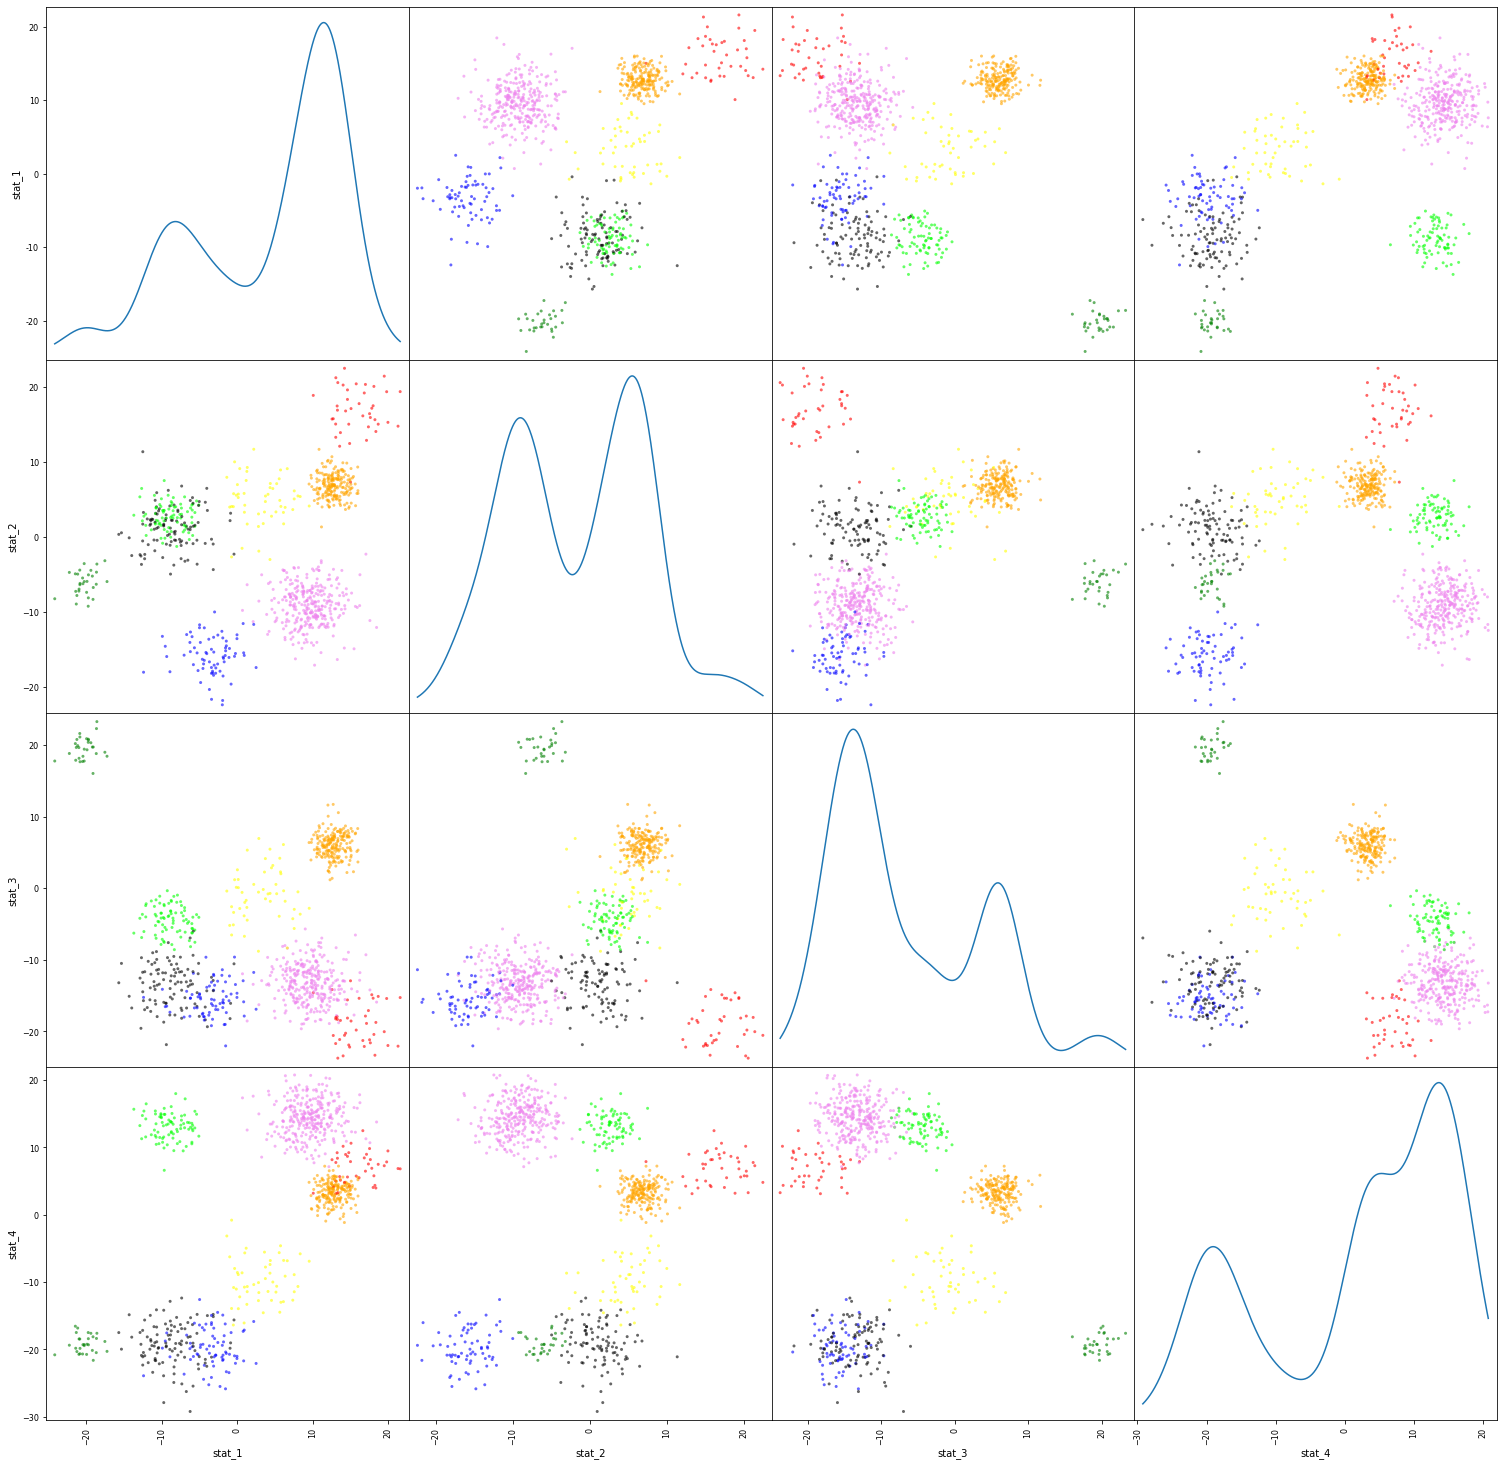

In [42]:
colors={'1':'green', '4':'red', '2':'blue', '3':'black', '5':'orange','6':'yellow','7':'lime','8':'violet'}
task2data['hierarchy_cluster'] = task2data['hierarchy_cluster'].astype(str)
scatter_matrix(task2data,figsize=(26,26), diagonal='kde',alpha=0.6, c=task2data['hierarchy_cluster'].replace(colors))

8 кластеров вполне достаточно. Но перепроверим с помощью метода k-средних.

In [43]:
hierarchy_cluster_result


0      2
1      8
2      8
3      3
4      8
      ..
865    8
866    5
867    8
868    5
869    8
Name: hierarchy_cluster, Length: 870, dtype: int32

In [44]:
w = {}
K = range(2,15)
for kluster_size in K:
    model = KMeans(n_clusters=kluster_size,random_state=42)
    model.fit(task2data)
    ss = silhouette_score(task2data, model.labels_)
    w[str(kluster_size)] = {'w' : model.inertia_, 'silhouette' : ss}
w

{'2': {'w': 229480.77597797711, 'silhouette': 0.4732082861497384},
 '3': {'w': 139750.66221527607, 'silhouette': 0.5278232568489664},
 '4': {'w': 104140.9239929968, 'silhouette': 0.5913680138769665},
 '5': {'w': 70453.97711254196, 'silhouette': 0.6320568643406103},
 '6': {'w': 45250.46207862123, 'silhouette': 0.687907162284947},
 '7': {'w': 31270.864526535795, 'silhouette': 0.6802481633682492},
 '8': {'w': 20709.485550077658, 'silhouette': 0.7017974635071709},
 '9': {'w': 19001.939290918333, 'silhouette': 0.5256118686933304},
 '10': {'w': 17966.076949136674, 'silhouette': 0.5217366157187806},
 '11': {'w': 17520.80994193821, 'silhouette': 0.4953413496288716},
 '12': {'w': 16731.898188605424, 'silhouette': 0.523386795010779},
 '13': {'w': 16273.280677296001, 'silhouette': 0.4732840671520579},
 '14': {'w': 15518.401555154001, 'silhouette': 0.34122392584244493}}

В качестве критерий качества (простите за тавтологию), использован силуэт.

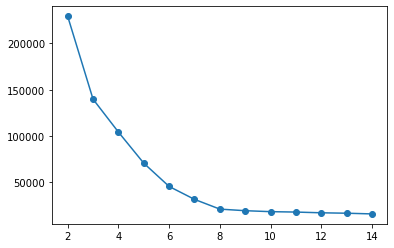

In [45]:
w_plot=list(map((lambda x: x.get('w')), w.values()))
plt.plot(K, w_plot,marker='o')


Судя по графику и цифрам, переход с 7 до 8 кластеров довольно сильно влияет на W, в отличии от дальнейших переходов. 
Остановимся так же на 8ми кластерах. Да и оценка силуэта говорит о том же.

In [46]:
model = KMeans(n_clusters=8,random_state=42)
model.fit(task2data)
task2data['kmean_cluster'] = model.labels_

In [47]:
task2data.groupby('kmean_cluster').mean()

,stat_1,stat_2,stat_3,stat_4
kmean_cluster,,,,
0,9.59,-9.16,-13.29,14.37
1,-3.42,-15.78,-15.47,-19.78
2,12.78,6.86,6.03,3.32
3,-20.17,-6.10,19.54,-19.20
4,-8.87,2.75,-4.43,13.06
5,15.92,16.86,-18.96,6.94
6,-8.63,1.15,-13.54,-19.22
7,3.25,4.90,-0.93,-9.72


Вспомним силуэт иерархической кластеризации.

In [48]:
silhouette_score(task2data, hierarchy_cluster_result)

0.7087586947844917

Получаем, что иерархическая кластеризация предпочтительнее.

К сожалению, о характеристиках каждого кластера ничего бизнесово-полезного сказать не получится, кроме простых наблюдений. В 1ом кластере характеристики 2,3,4 принимают отрицательные значения, в 5ом -
характеристики 1 и 2 положительны и т.д. 

p.s.
Можно предположить, что это температуры в населённых пунктах по четырём сезонам года, тогда становится веселее :-)